# Team #5 Exploratory Data Analysis

Beth, Bushra, Karthi, Geeta, Ha, Ramya


---



In [ ]:
# to load the housing data drive go to google drive, 
# right click the housing data folder and add shortcut to drive, save in MyDrive

# mount google drive with data folders
from google.colab import drive
drive.mount('/content/drive/')

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# install and import packages 
!pip install arch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import datetime
from statsmodels.tsa.stattools import adfuller
from arch.unitroot import ADF
from arch.unitroot import engle_granger
from itertools import combinations

# modeling
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# load merged data file
df = pd.read_csv('/content/drive/MyDrive/ds4_housing_data/housing_data_for_eda.csv')
df = df.drop(['Unnamed: 0'], axis=1)
df['time'] = pd.to_datetime(df['time'])
df = df.loc[df['time'].dt.year >= 2004]
df = df.loc[df['time'] < '2022-06-01']
df = df.groupby('time').mean().reset_index()
df = df.drop(['median_house_value', 'median_tax_paid'], axis=1)
df["work_home_rate"] = df["work_home_rate"].fillna(6)

## Checking data dimensions, distributions, and feature types (Ramya)



---





In [ ]:
# Ramya -> Check data dimensions, distributions, categorical/quantitative features

#No of elements: (rows* columns)
print('size', df.size)

#No of rows, columns:
print('shape', df.shape)

#Dimension of df:
print('number of dimensions', df.ndim)

#number of non-missing values and data types of each column:
print('info about dataset', df.info())

#to get the statistics of numeric columns:
df.describe().T

size 2431
shape (221, 11)
number of dimensions 2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221 entries, 0 to 220
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   time                     221 non-null    datetime64[ns]
 1   housing_price            221 non-null    float64       
 2   rental_price             221 non-null    float64       
 3   inflation_rate           221 non-null    float64       
 4   property_tax_rate        19 non-null     float64       
 5   median_age_homebuyers    18 non-null     float64       
 6   housing_starts           221 non-null    float64       
 7   interest_rate            221 non-null    float64       
 8   mortgage_rate            221 non-null    float64       
 9   mortgage_to_income_rate  73 non-null     float64       
 10  work_home_rate           221 non-null    float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 

,count,mean,std,min,25%,50%,75%,max
housing_price,221.0,210851.384615,39143.597188,164701.00000,180805.000000,203052.000000,225038.000000,349816.000000
rental_price,221.0,275.296810,43.413056,208.30000,244.181000,265.821000,311.501000,365.116000
inflation_rate,221.0,234.840860,24.454149,194.60000,216.393000,232.794000,253.526000,292.289000
property_tax_rate,19.0,1.079206,0.103537,0.90000,0.972324,1.100000,1.168440,1.210586
median_age_homebuyers,18.0,42.777778,2.819169,39.00000,40.250000,43.000000,45.000000,47.000000
housing_starts,221.0,1209.592760,454.248807,478.00000,886.000000,1181.000000,1530.000000,2273.000000
interest_rate,221.0,1.267511,1.616377,0.05000,0.110000,0.340000,2.000000,5.260000
mortgage_rate,221.0,4.578378,1.087625,2.68400,3.765000,4.330000,5.635000,6.762500
mortgage_to_income_rate,73.0,5.272967,1.134166,3.50548,4.250093,4.934149,6.351318,7.183105
work_home_rate,221.0,7.541629,5.040877,6.00000,6.000000,6.000000,6.000000,38.000000


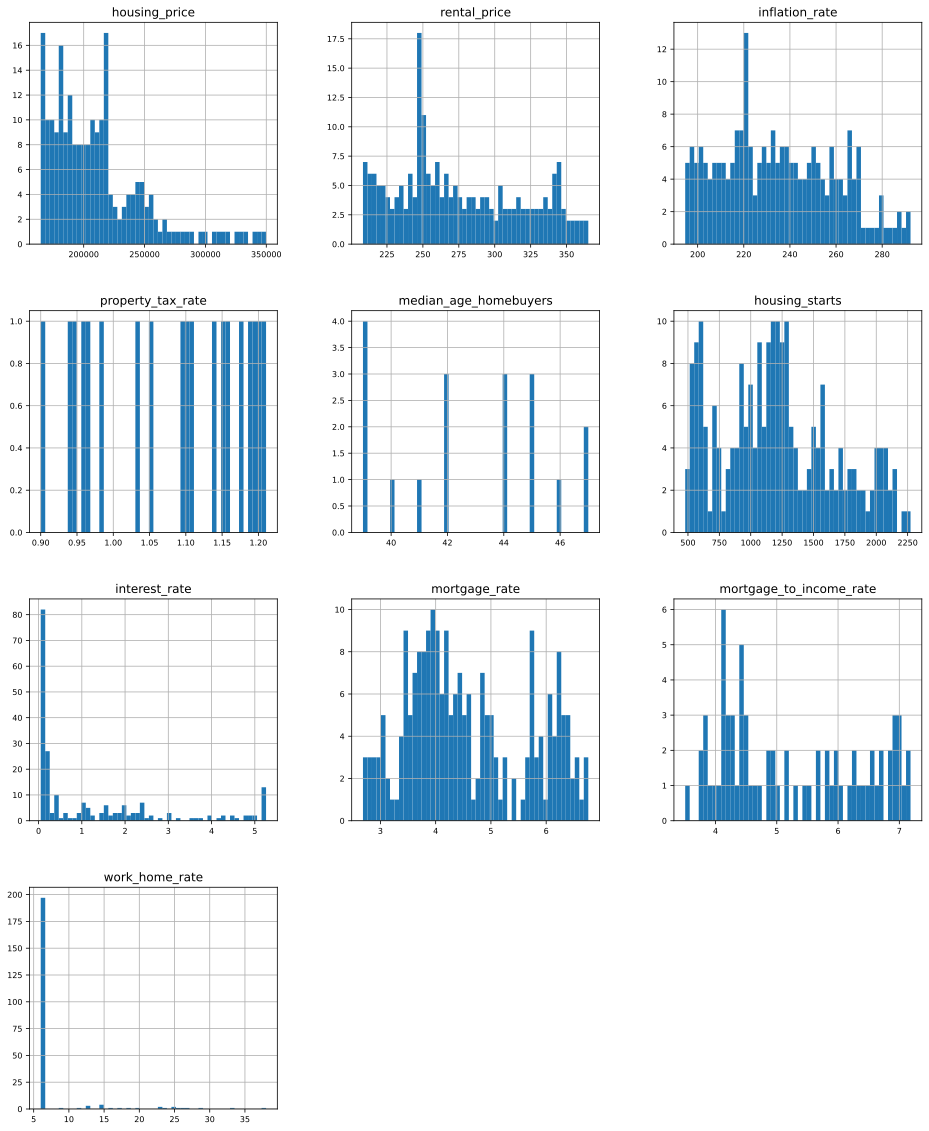

In [ ]:
#Distribution
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [ ]:
# change age to astype factor

df['median_age_homebuyers'] = df['median_age_homebuyers'].astype('object')

#categorical features
print('categorical features', df.select_dtypes(include=['object']).columns.tolist())

#numerical features
print('numerical features', df.select_dtypes(exclude=['object']).columns.tolist())

categorical features ['median_age_homebuyers']
numerical features ['time', 'housing_price', 'rental_price', 'inflation_rate', 'property_tax_rate', 'housing_starts', 'interest_rate', 'mortgage_rate', 'mortgage_to_income_rate', 'work_home_rate']


## Check for duplicates, null values, and outliers (Geeta)


---



In [ ]:
# Geeta -> Check for duplicates, null values, and outliers.

#check whether duplicates are available
print('duplicates', df.duplicated().sum())

#to drop duplicates 
df.drop_duplicates()

#to check the number of null values
print(df.isnull().sum())

duplicates 0
time                         0
housing_price                0
rental_price                 0
inflation_rate               0
property_tax_rate          202
median_age_homebuyers      203
housing_starts               0
interest_rate                0
mortgage_rate                0
mortgage_to_income_rate    148
work_home_rate               0
dtype: int64


## Correcting for missing time point data (Beth)


---



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


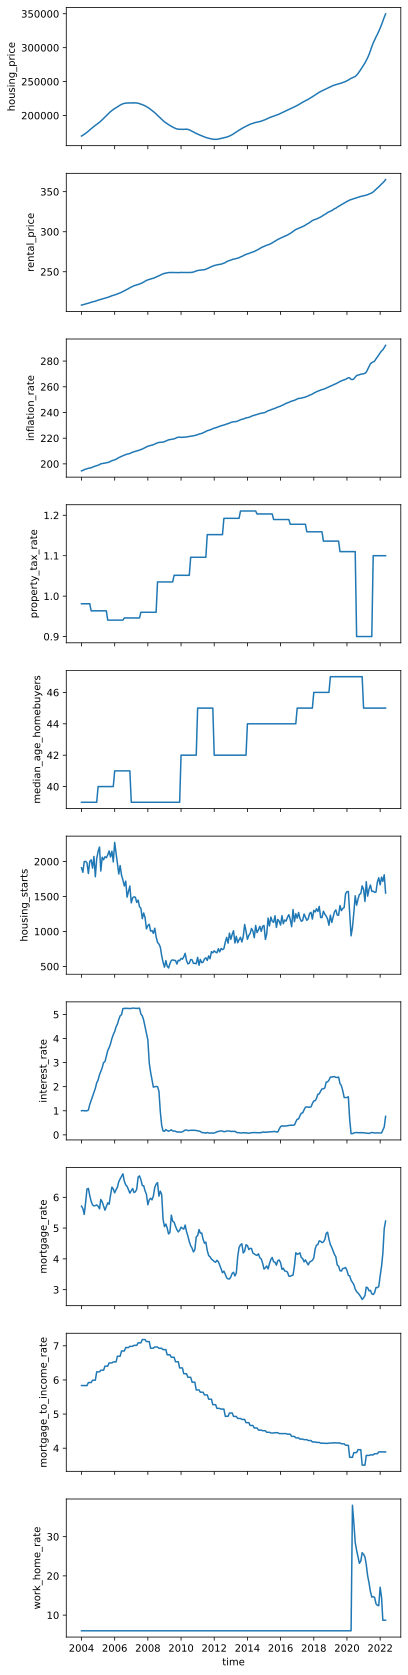

In [ ]:
# beth --- > how to deal with missing time point data in models, 
df['rental_price'] = df['rental_price'].interpolate(method='nearest')
df['housing_price'] = df['housing_price'].interpolate(method='nearest')
df['property_tax_rate'] = df['property_tax_rate'].interpolate(method='nearest')
df['inflation_rate'] = df['inflation_rate'].interpolate(method='nearest')
df['property_tax_rate'] = df['property_tax_rate'].interpolate(method='nearest')
df['median_age_homebuyers'] = df['median_age_homebuyers'].interpolate(method='nearest')
df['housing_starts'] = df['housing_starts'].interpolate(method='nearest')
df['interest_rate'] = df['interest_rate'].interpolate(method='nearest')
df['mortgage_to_income_rate'] = df['mortgage_to_income_rate'].interpolate(method='nearest')
df['work_home_rate'] = df['work_home_rate'].fillna(0)
df['work_home_rate'][-3:] = 8.7

df = df.ffill(axis = 0)

# plot the filled data 
fig, axs = plt.subplots(sharex=True, nrows=10, figsize=(6,30))
sns.lineplot(x=df['time'],y=df['housing_price'],  ax=axs[0] )
sns.lineplot(x=df['time'],y= df['rental_price'],  ax=axs[1] )
sns.lineplot(x=df['time'],y= df['inflation_rate'],  ax=axs[2] )
sns.lineplot(x=df['time'],y=df['property_tax_rate'],  ax=axs[3] )
sns.lineplot(x=df['time'],y= df[ 'median_age_homebuyers'],  ax=axs[4] )
sns.lineplot(x=df['time'],y= df['housing_starts'],  ax=axs[5] )
sns.lineplot(x=df['time'],y=df[ 'interest_rate'],  ax=axs[6] )
sns.lineplot(x=df['time'],y= df[ 'mortgage_rate'],  ax=axs[7] )
sns.lineplot(x=df['time'],y= df['mortgage_to_income_rate'],  ax=axs[8] )
sns.lineplot(x=df['time'],y= df['work_home_rate'],  ax=axs[9] )

## Compute descriptive statistics (Bushra)


---



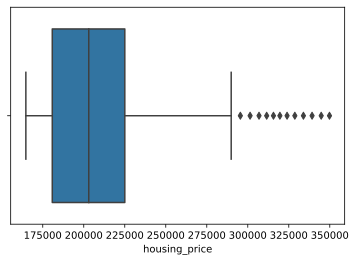

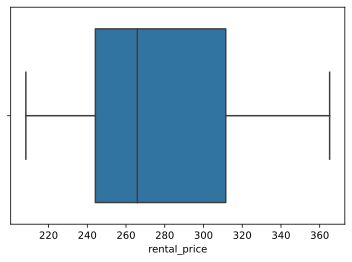

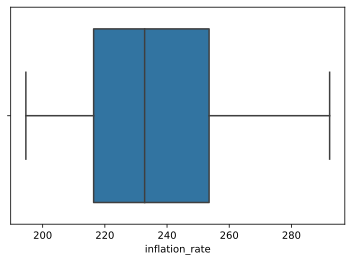

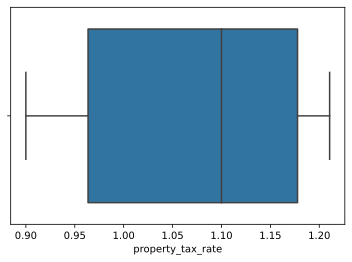

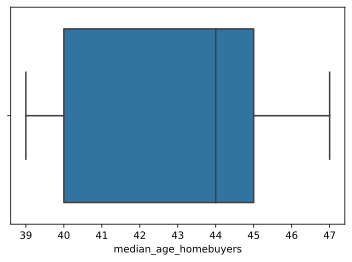

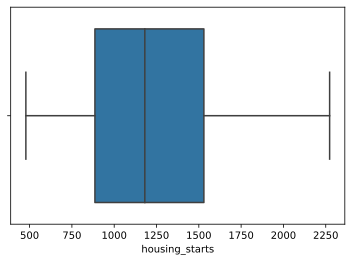

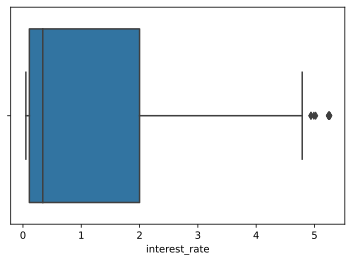

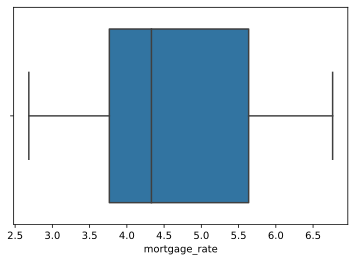

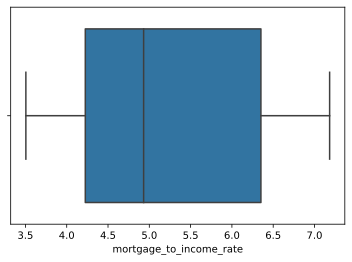

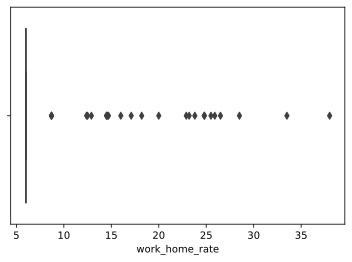

In [ ]:
#Box plots_Percentile and IQR
df_box=df.drop(columns = ['time'])
for i in df_box.columns:
    sns.boxplot(x=df_box[i], orient='horizontal')
    plt.show()


## Check for assumptions (Ha)


---



In [ ]:
#---------- 1. Augmented Dickey-Fuller (ADF) test for stationary (unit root)
#H0: series has unit root (not stationary)
#H1: series is weakly stationary --- good
#P-value > 0.05: not reject H0 ----> need to make transformation

column_headers = list(df.columns.values)

for column in column_headers[1:]:
  print(column, ADF(df[column], trend="c") )

# Conclusion: those series below are not stationary at 5%
#             housing_price, rental_price, inflation_rate, property_tax_rate, median_age_homebuyers, 
#             housing_starts, mortgage_rate, mortgage_to_income_rate, work_home_rate

#----------- 2. Test for Cointegration (engle_granger)
#H0: Two series have no cointegration      ---- good
#H1: there is cointegration between 2 series
#P-value <= 0.05: reject H0 ---> need to be careful when model the two series

for column1, column2 in combinations(column_headers[1:],2):
  eg_test = engle_granger(df[column1], df[column2], trend="n")
  print(column1, column2, eg_test)

# Conclusion: There is no cointegration at 5% --- GOOD!

housing_price    Augmented Dickey-Fuller Results   
Test Statistic                  1.512
P-value                         0.998
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.88 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
rental_price    Augmented Dickey-Fuller Results   
Test Statistic                  2.712
P-value                         0.999
Lags                               15
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.88 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
inflation_rate    Augmented Dickey-Fuller Results   
Test Statistic                  1.980
P-value                         0.999
Lags                               12
-------------------------------------

Trend: Constant
Critical Valu

In [ ]:
#---------- 3. take first (second) difference/log to make it stationary (detrend & seasonality)
# housing_price, rental_price, inflation_rate, property_tax_rate, median_age_homebuyers, housing_starts, 
# mortgage_rate, mortgage_to_income_rate, work_home_rate

df = df.sort_values(by=['time'], ascending=True)

df['diff_housing_price'] = df['housing_price'].diff().diff()    
df['diff_rental_price'] = df['rental_price'].diff().diff()
df['diff_inflation_rate'] = df['inflation_rate'].diff().diff()
df['diff_property_tax_rate'] = df['property_tax_rate'].diff()
df['diff_median_age_homebuyers'] = df['median_age_homebuyers'].diff()
df['diff_housing_starts'] = df['housing_starts'].diff()
df['diff_mortgage_rate'] = df['mortgage_rate'].diff()
df['diff_mortgage_to_income_rate'] = df['mortgage_to_income_rate'].diff().diff()
df['diff_work_home_rate'] = df['work_home_rate'].diff()
df['diff_interest_rate'] = df['interest_rate']

# CONCLUSION: 
# variables are stationary after first-order difference (x't=x_{t} - x_{t-1}): property_tax_rate, median_age_homebuyers, housing_starts, mortgage_rate, work_home_rate
# variables are stationary after second-order difference (x"t = x't - x't-1 = (xt - xt-1) - (xt-1 - xt-2) = xt - 2xt-1 + xt-2): housing_price, rental_price, inflation_rate, mortgage_to_income_rate
# variable is stationary without any transformation: interest_rate


In [ ]:
#---------- 4. ADF test again for stationary (unit root) of transformed series
#H0: series has unit root (not stationary)
#H1: series is weakly stationary --- good
#P-value > 0.05: not reject H0 ----> need to make transformation

column_headers = list(df.columns.values)

for column in column_headers[11:]:
  print(column, ADF(df[column].dropna(), trend="c") )

# Conclusion: all series are stationary ---> GOOD to proceed!  

diff_housing_price    Augmented Dickey-Fuller Results   
Test Statistic                 -3.817
P-value                         0.003
Lags                               10
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.88 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
diff_rental_price    Augmented Dickey-Fuller Results   
Test Statistic                 -8.597
P-value                         0.000
Lags                                6
-------------------------------------

Trend: Constant
Critical Values: -3.46 (1%), -2.88 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
diff_inflation_rate    Augmented Dickey-Fuller Results   
Test Statistic                 -4.722
P-value                         0.000
Lags                               10
-------------------------------------

Trend: Constan

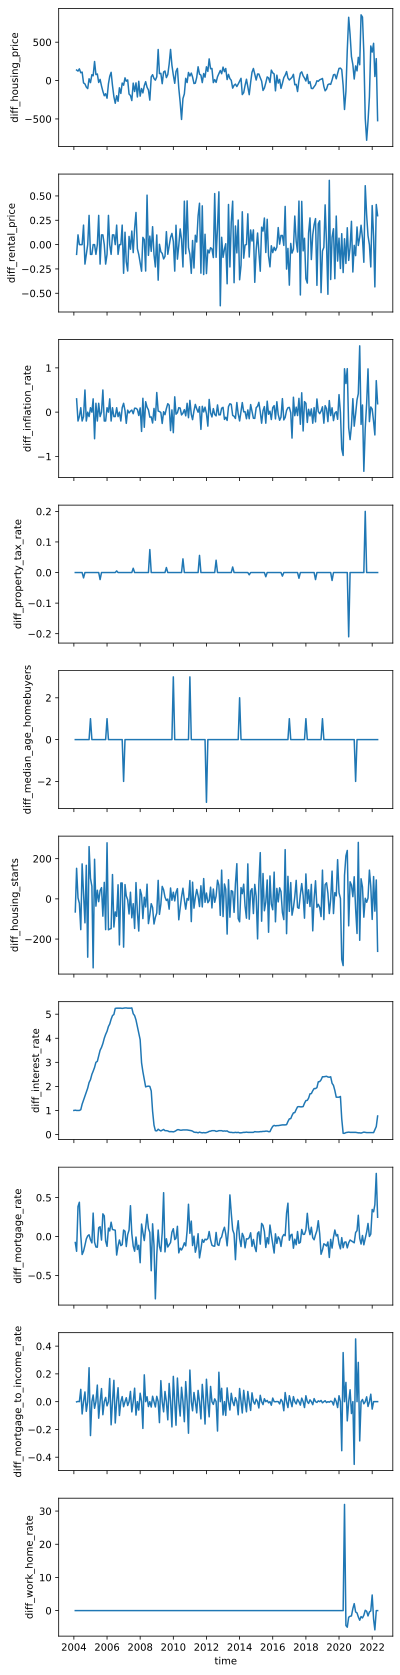

In [ ]:
# plot the transformed data (stationary, no cointegration)
fig, axs = plt.subplots(sharex=True, nrows=10, figsize=(6,30))
sns.lineplot(x=df['time'],y=df['diff_housing_price'],  ax=axs[0] )
sns.lineplot(x=df['time'],y= df['diff_rental_price'],  ax=axs[1] )
sns.lineplot(x=df['time'],y= df['diff_inflation_rate'],  ax=axs[2] )
sns.lineplot(x=df['time'],y=df['diff_property_tax_rate'],  ax=axs[3] )
sns.lineplot(x=df['time'],y= df[ 'diff_median_age_homebuyers'],  ax=axs[4] )
sns.lineplot(x=df['time'],y= df['diff_housing_starts'],  ax=axs[5] )
sns.lineplot(x=df['time'],y=df[ 'diff_interest_rate'],  ax=axs[6] )
sns.lineplot(x=df['time'],y= df[ 'diff_mortgage_rate'],  ax=axs[7] )
sns.lineplot(x=df['time'],y= df['diff_mortgage_to_income_rate'],  ax=axs[8] )
sns.lineplot(x=df['time'],y= df['diff_work_home_rate'],  ax=axs[9] )

In [ ]:
# Select data from 2005
df = df.loc[df['time'] >= '2005-01-01']
df = df.loc[df['time'] < '2022-06-01']

## Plot correlation plots (Beth) 


---





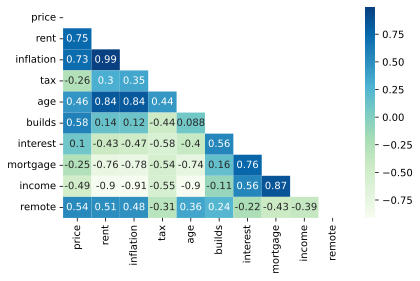

In [ ]:
# Beth --> plot correlation plots
df_vars = df.iloc[:,1:11]

palette = sns.diverging_palette(359, 165, s=100, as_cmap=True)

df_vars.columns = ['price', 'rent', 'inflation', 'tax', 'age', 'builds', 'interest', 'mortgage', 'income', 'remote']

corr = df_vars.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, cmap="GnBu", mask=mask, annot=True)

# 'coolwarm', 'RdBu_r', 'BrBG_r', & PuOr_r are other good diverging colormaps
# viridis, plasma, or PrGn colormaps might match the datafolio better
plt.tight_layout()
plt.savefig('heatmap.png', dpi=400, transparent=True)


## Visualize trends


---



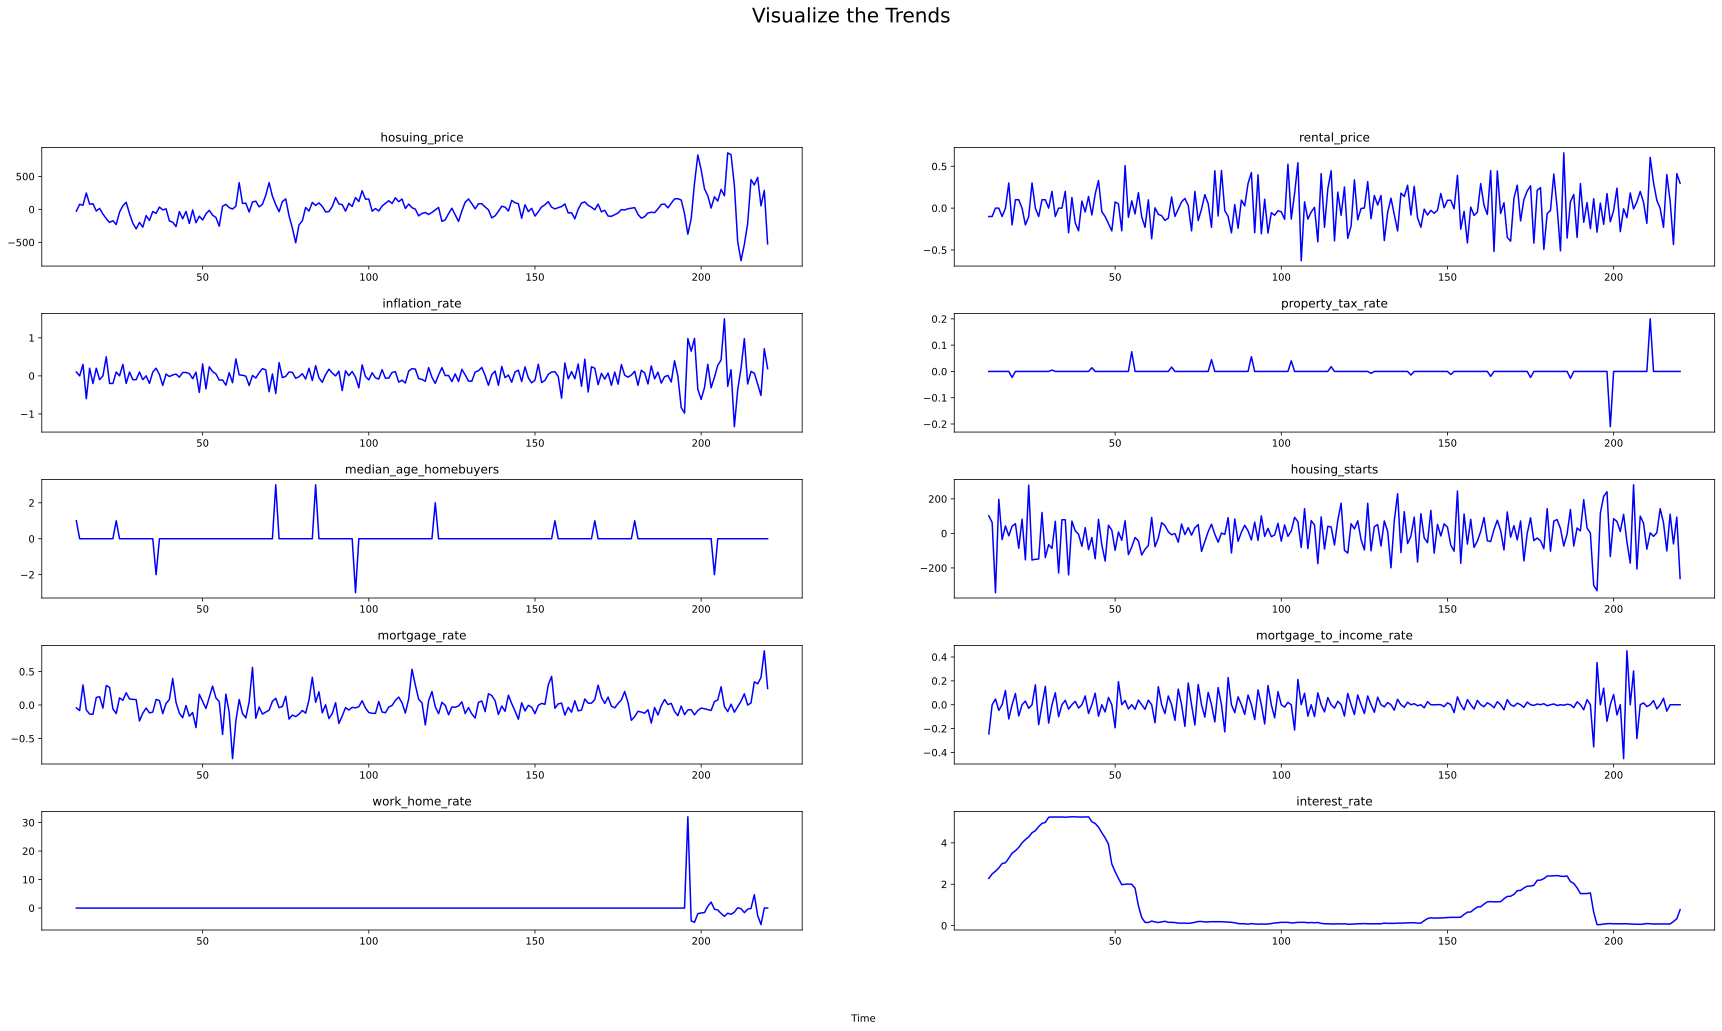

In [ ]:
#Visualize Trend

labels=df.columns
fig=plt.figure(figsize=(30,15))
fig.subplots_adjust(hspace=0.4,top=0.85)
fig.suptitle('Visualize the Trends', fontsize=20)
fig.tight_layout()
ax1 = fig.add_subplot(5,2,1)
ax2 = fig.add_subplot(5,2,2)
ax3 = fig.add_subplot(5,2,3)
ax4 = fig.add_subplot(5,2,4)
ax5 = fig.add_subplot(5,2,5)
ax6 = fig.add_subplot(5,2,6)
ax7 = fig.add_subplot(5,2,7)
ax8 = fig.add_subplot(5,2,8)
ax9 = fig.add_subplot(5,2,9)
ax10 = fig.add_subplot(5,2,10)
ax1.plot(df['diff_housing_price'], '-', color='b')
ax1.set_title('hosuing_price')
ax2.plot(df['diff_rental_price'], '-', color='b')
ax2.set_title('rental_price')
ax3.plot(df['diff_inflation_rate'], '-', color='b')
ax3.set_title('inflation_rate')
ax4.plot(df['diff_property_tax_rate'], '-', color='b')
ax4.set_title('property_tax_rate')
ax5.plot(df['diff_median_age_homebuyers'], '-', color='b')
ax5.set_title('median_age_homebuyers')
ax6.plot(df['diff_housing_starts'], '-', color='b')
ax6.set_title('housing_starts')
ax7.plot(df['diff_mortgage_rate'], '-', color='b')
ax7.set_title('mortgage_rate')
ax8.plot(df['diff_mortgage_to_income_rate'], '-', color='b')
ax8.set_title('mortgage_to_income_rate')
ax9.plot(df['diff_work_home_rate'], '-', color='b')
ax9.set_title('work_home_rate')
ax10.plot(df['diff_interest_rate'], '-', color='b')
ax10.set_title('interest_rate')
fig.text(0.5, 0.04, 'Time')
plt.show()

## Rolling Mean and Standard Deviation


---



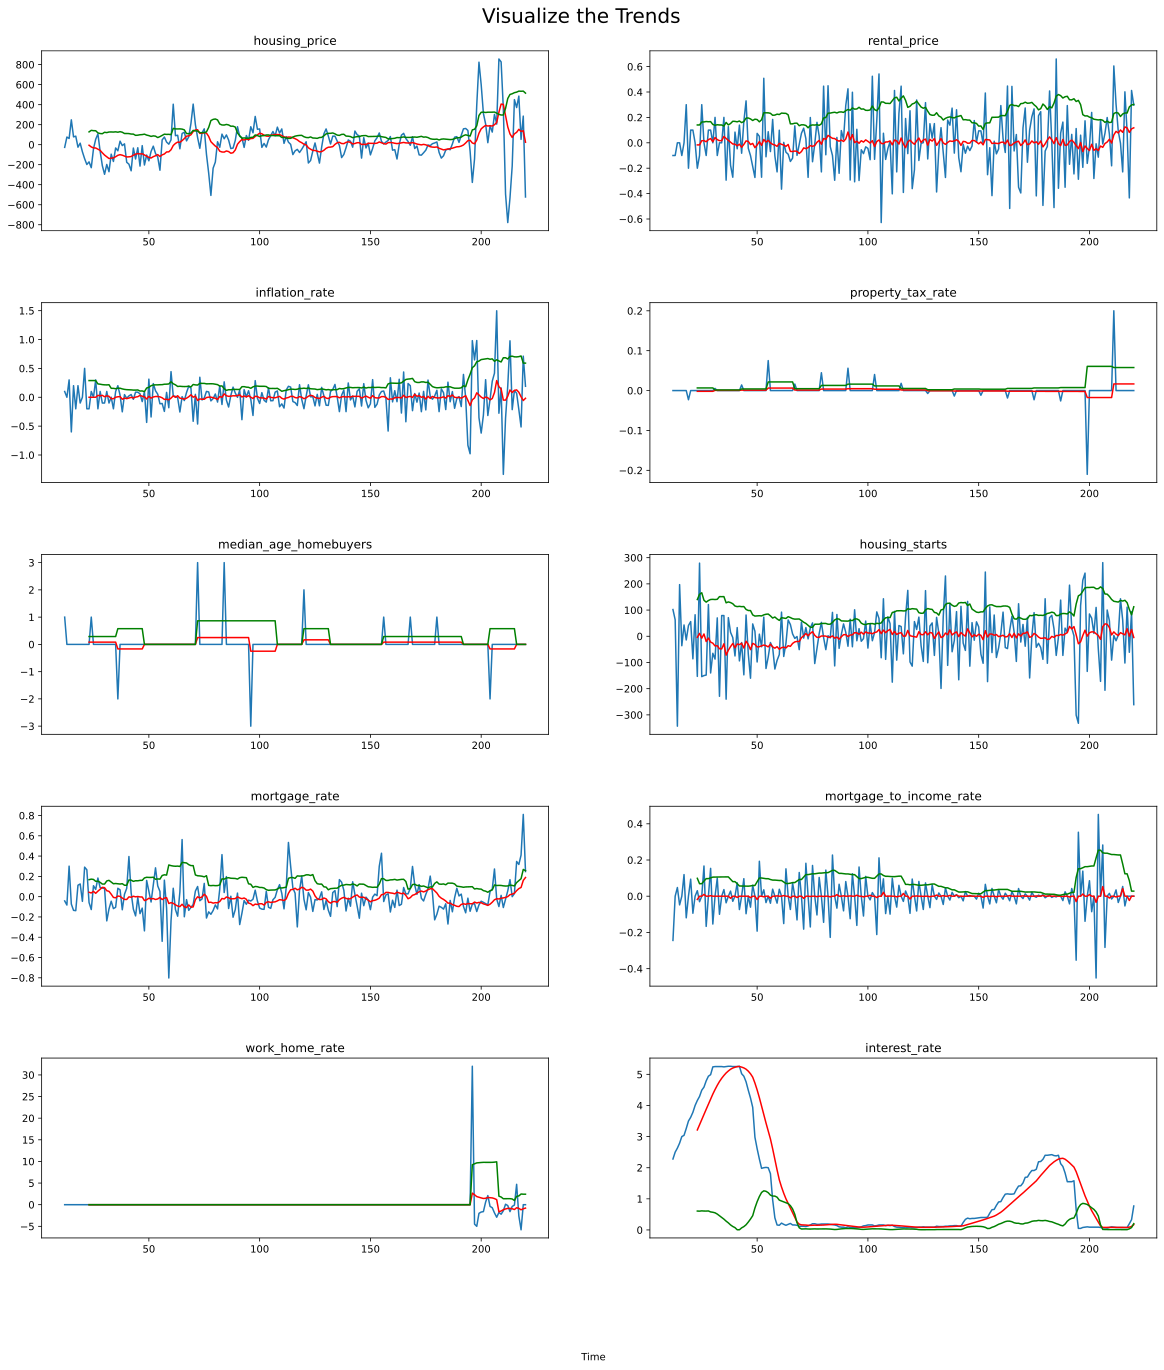

In [ ]:
#Rolling Mean And Standard Deviation
labels=df.columns
fig=plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0.4,top=0.95)
fig.suptitle('Visualize the Trends', fontsize=20)
fig.tight_layout()
ax1 = fig.add_subplot(5,2,1)
ax2 = fig.add_subplot(5,2,2)
ax3 = fig.add_subplot(5,2,3)
ax4 = fig.add_subplot(5,2,4)
ax5 = fig.add_subplot(5,2,5)
ax6 = fig.add_subplot(5,2,6)
ax7 = fig.add_subplot(5,2,7)
ax8 = fig.add_subplot(5,2,8)
ax9 = fig.add_subplot(5,2,9)
ax10 = fig.add_subplot(5,2,10)
ax1.plot(df['diff_housing_price'], '-',label='Original')
ax1.plot(df['diff_housing_price'].rolling(window = 12).mean(), color = 'red', label = 'Rolling Mean')
ax1.plot(df['diff_housing_price'].rolling(window = 12).std(), color = 'green', label = 'Rolling Std')
ax1.set_title('housing_price')
ax2.plot(df['diff_rental_price'], '-',label='Original')
ax2.plot(df['diff_rental_price'].rolling(window = 12).mean(), color = 'red', label = 'Rolling Mean')
ax2.plot(df['diff_rental_price'].rolling(window = 12).std(), color = 'green', label = 'Rolling Std')
ax2.set_title('rental_price')
ax3.plot(df['diff_inflation_rate'], '-',label='Original')
ax3.plot(df['diff_inflation_rate'].rolling(window = 12).mean(), color = 'red', label = 'Rolling Mean')
ax3.plot(df['diff_inflation_rate'].rolling(window = 12).std(), color = 'green', label = 'Rolling Std')
ax3.set_title('inflation_rate')
ax4.plot(df['diff_property_tax_rate'], '-',label='Original')
ax4.plot(df['diff_property_tax_rate'].rolling(window = 12).mean(), color = 'red', label = 'Rolling Mean')
ax4.plot(df['diff_property_tax_rate'].rolling(window = 12).std(), color = 'green', label = 'Rolling Std')
ax4.set_title('property_tax_rate')
ax5.plot(df['diff_median_age_homebuyers'], '-',label='Original')
ax5.plot(df['diff_median_age_homebuyers'].rolling(window = 12).mean(), color = 'red', label = 'Rolling Mean')
ax5.plot(df['diff_median_age_homebuyers'].rolling(window = 12).std(), color = 'green', label = 'Rolling Std')
ax5.set_title('median_age_homebuyers')
ax6.plot(df['diff_housing_starts'], '-',label='Original')
ax6.plot(df['diff_housing_starts'].rolling(window = 12).mean(), color = 'red', label = 'Rolling Mean')
ax6.plot(df['diff_housing_starts'].rolling(window = 12).std(), color = 'green', label = 'Rolling Std')
ax6.set_title('housing_starts')
ax7.plot(df['diff_mortgage_rate'], '-',label='Original')
ax7.plot(df['diff_mortgage_rate'].rolling(window = 12).mean(), color = 'red', label = 'Rolling Mean')
ax7.plot(df['diff_mortgage_rate'].rolling(window = 12).std(), color = 'green', label = 'Rolling Std')
ax7.set_title('mortgage_rate')
ax8.plot(df['diff_mortgage_to_income_rate'], '-',label='Original')
ax8.plot(df['diff_mortgage_to_income_rate'].rolling(window = 12).mean(), color = 'red', label = 'Rolling Mean')
ax8.plot(df['diff_mortgage_to_income_rate'].rolling(window = 12).std(), color = 'green', label = 'Rolling Std')
ax8.set_title('mortgage_to_income_rate')
ax9.plot(df['diff_work_home_rate'], '-',label='Original')
ax9.plot(df['diff_work_home_rate'].rolling(window = 12).mean(), color = 'red', label = 'Rolling Mean')
ax9.plot(df['diff_work_home_rate'].rolling(window = 12).std(), color = 'green', label = 'Rolling Std')
ax9.set_title('work_home_rate')
ax10.plot(df['diff_interest_rate'], '-',label='Original')
ax10.plot(df['diff_interest_rate'].rolling(window = 12).mean(), color = 'red', label = 'Rolling Mean')
ax10.plot(df['diff_interest_rate'].rolling(window = 12).std(), color = 'green', label = 'Rolling Std')
ax10.set_title('interest_rate')
fig.text(0.5, 0.04, 'Time')
plt.show()

"""rolling_mean = df.rolling(window = 12).mean()
rolling_std = df.rolling(window = 12).std()
plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')"""
plt.show()

## Visualize auto-correlation and partial autocorrelation


---



/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsap

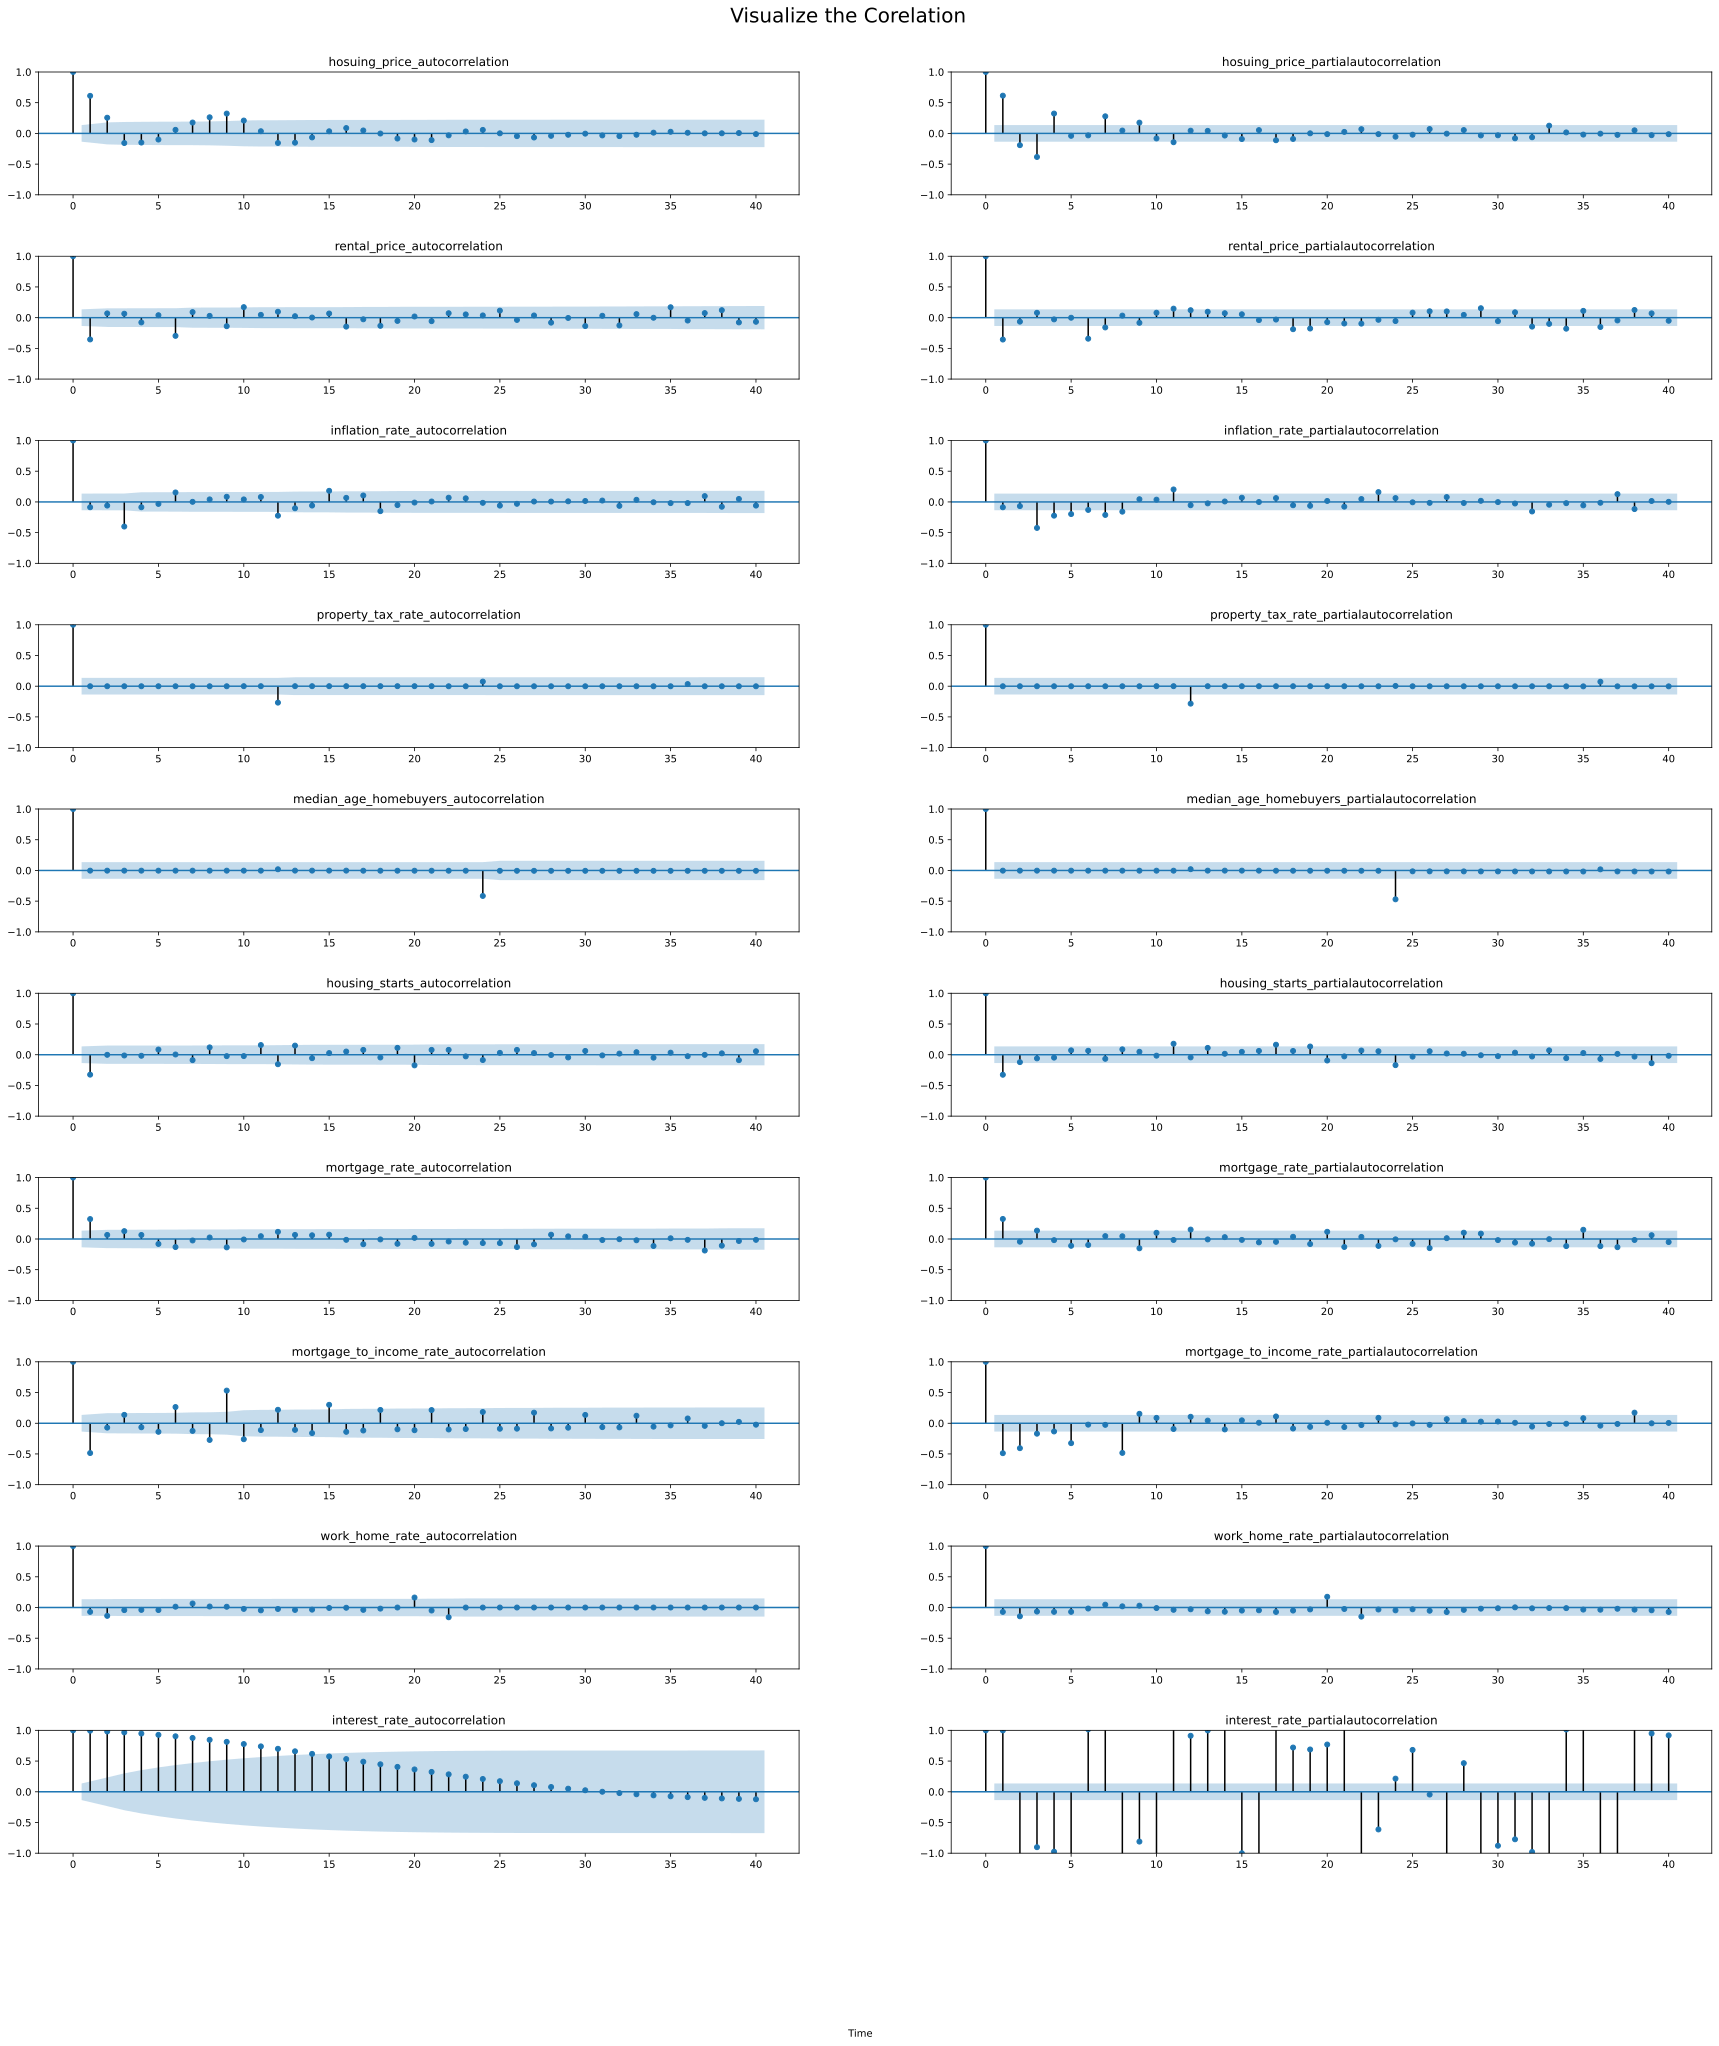

In [ ]:
#Visualize Correlation

fig=plt.figure(figsize=(30,30))
fig.subplots_adjust(hspace=0.5,top=0.95)
fig.suptitle('Visualize the Corelation', fontsize=20)
fig.tight_layout()
ax1 = fig.add_subplot(10,2,1)
ax2 = fig.add_subplot(10,2,2)
ax3 = fig.add_subplot(10,2,3)
ax4 = fig.add_subplot(10,2,4)
ax5 = fig.add_subplot(10,2,5)
ax6 = fig.add_subplot(10,2,6)
ax7 = fig.add_subplot(10,2,7)
ax8 = fig.add_subplot(10,2,8)
ax9 = fig.add_subplot(10,2,9)
ax10 = fig.add_subplot(10,2,10)
ax11 = fig.add_subplot(10,2,11)
ax12 = fig.add_subplot(10,2,12)
ax13 = fig.add_subplot(10,2,13)
ax14 = fig.add_subplot(10,2,14)
ax15 = fig.add_subplot(10,2,15)
ax16 = fig.add_subplot(10,2,16)
ax17 = fig.add_subplot(10,2,17)
ax18 = fig.add_subplot(10,2,18)
ax19 = fig.add_subplot(10,2,19)
ax20 = fig.add_subplot(10,2,20)
fig = sm.graphics.tsa.plot_acf(df['diff_housing_price'],lags=40,ax=ax1)
fig = sm.graphics.tsa.plot_pacf(df['diff_housing_price'],lags=40,ax=ax2)
ax1.set_title('hosuing_price_autocorrelation')
ax2.set_title('hosuing_price_partialautocorrelation')

fig = sm.graphics.tsa.plot_acf(df['diff_rental_price'],lags=40,ax=ax3)
fig = sm.graphics.tsa.plot_pacf(df['diff_rental_price'],lags=40,ax=ax4)
ax3.set_title('rental_price_autocorrelation')
ax4.set_title('rental_price_partialautocorrelation')


fig = sm.graphics.tsa.plot_acf(df['diff_inflation_rate'],lags=40,ax=ax5)
fig = sm.graphics.tsa.plot_pacf(df['diff_inflation_rate'],lags=40,ax=ax6)
ax5.set_title('inflation_rate_autocorrelation')
ax6.set_title('inflation_rate_partialautocorrelation')



fig = sm.graphics.tsa.plot_acf(df['diff_property_tax_rate'],lags=40,ax=ax7)
fig = sm.graphics.tsa.plot_pacf(df['diff_property_tax_rate'],lags=40,ax=ax8)
ax7.set_title('property_tax_rate_autocorrelation')
ax8.set_title('property_tax_rate_partialautocorrelation')



fig = sm.graphics.tsa.plot_acf(df['diff_median_age_homebuyers'],lags=40,ax=ax9)
fig = sm.graphics.tsa.plot_pacf(df['diff_median_age_homebuyers'],lags=40,ax=ax10)
ax9.set_title('median_age_homebuyers_autocorrelation')
ax10.set_title('median_age_homebuyers_partialautocorrelation')


fig = sm.graphics.tsa.plot_acf(df['diff_housing_starts'],lags=40,ax=ax11)
fig = sm.graphics.tsa.plot_pacf(df['diff_housing_starts'],lags=40,ax=ax12)
ax11.set_title('housing_starts_autocorrelation')
ax12.set_title('housing_starts_partialautocorrelation')

fig = sm.graphics.tsa.plot_acf(df['diff_mortgage_rate'],lags=40,ax=ax13)
fig = sm.graphics.tsa.plot_pacf(df['diff_mortgage_rate'],lags=40,ax=ax14)
ax13.set_title('mortgage_rate_autocorrelation')
ax14.set_title('mortgage_rate_partialautocorrelation')


fig = sm.graphics.tsa.plot_acf(df['diff_mortgage_to_income_rate'],lags=40,ax=ax15)
fig = sm.graphics.tsa.plot_pacf(df['diff_mortgage_to_income_rate'],lags=40,ax=ax16)
ax15.set_title('mortgage_to_income_rate_autocorrelation')
ax16.set_title('mortgage_to_income_rate_partialautocorrelation')

fig = sm.graphics.tsa.plot_acf(df['diff_work_home_rate'],lags=40,ax=ax17)
fig = sm.graphics.tsa.plot_pacf(df['diff_work_home_rate'],lags=40,ax=ax18)
ax17.set_title('work_home_rate_autocorrelation')
ax18.set_title('work_home_rate_partialautocorrelation')

fig = sm.graphics.tsa.plot_acf(df['diff_interest_rate'],lags=40,ax=ax19)
fig = sm.graphics.tsa.plot_pacf(df['diff_interest_rate'],lags=40,ax=ax20)
ax19.set_title('interest_rate_autocorrelation')
ax20.set_title('interest_rate_partialautocorrelation')

fig.text(0.5, 0.04, 'Time')
plt.show()

# Save processed data to csv for modeling!


---



In [ ]:
df.to_csv('/content/drive/MyDrive/ds4_housing_data/housing_data_for_modeling_v2.csv')

In [ ]:
# snapshot to submit pdf
!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
from colab_pdf import colab_pdf
colab_pdf('team5_EDA.ipynb')

--2022-07-27 15:52:55--  https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1864 (1.8K) [text/plain]
Saving to: ‘colab_pdf.py’

colab_pdf.py        100%[===================>]   1.82K  --.-KB/s    in 0s      

2022-07-27 15:52:55 (27.1 MB/s) - ‘colab_pdf.py’ saved [1864/1864]



ValueError: ignored